# Group 9 Project Proposal: Developing a Classification Model for Pulsar Stars

# Introduction


What are pulsar stars, and what can be used to classify one? Pulsar stars are known as neutron stars and remnants of dead massive stars. With each rotation, these stars release a periodic radio emission pattern detectable on Earth. However, these emissions are not uniform, so to classify the emission pattern the average of the emissions must be taken. Nearly all detections can be misidentified as pulsar stars, however, this is due to the involvement of radio frequency interference and noise. To combat this, machines are being trained to classify pulsar stars. We are investigating a pulsar star dataset$^1$ involving 8 variables, 4 of which are based on the integrated profile (IP) and 4 of which are based on the dispersion measure signal-to-noise ratio (DM-SNR). Our goal is to complete binary classifications of pulsar stars based off of these variables. Through training models with different combinations of these variables, we more specifically ask the question of what is the most effective way for astronomers to measure and observe pulsar stars?

# Preliminary Exploratory Data Analysis

In [1]:
#loading packages
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(GGally)

#setting the seed
set.seed(2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#reading data in from the web and making sure it is tidy
#0 codes for non-pulsar stars, 1 codes for pulsar stars within the class variable

star_data <- read_csv("https://raw.githubusercontent.com/natashawong03/dsci100_group_project/main/HTRU_2.csv", col_names = FALSE)

star_data <- rename(star_data,
IP_mean = X1,
IP_std = X2,
IP_exk = X3,
IP_skw = X4,
DM_mean = X5,
DM_std = X6,
DM_exk = X7,
DM_skw = X8,
Class = X9) 

head(star_data, n=9)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


IP_mean,IP_std,IP_exk,IP_skw,DM_mean,DM_std,DM_exk,DM_skw,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,0


In [3]:
#now we are going to change the class variable to a factor and subset our data into training and testing dataframes
star_data <- star_data |>
  mutate(Class = as_factor(Class))

star_split <- initial_split(star_data, prop = 0.75, strata = Class)
star_train <- training(star_split)
star_test <- testing(star_split)

In [4]:
#prelim data analysis
summary(star_train)

    IP_mean            IP_std          IP_exk             IP_skw       
 Min.   :  5.812   Min.   :24.77   Min.   :-1.70779   Min.   :-1.7919  
 1st Qu.:101.051   1st Qu.:42.39   1st Qu.: 0.02726   1st Qu.:-0.1892  
 Median :115.133   Median :46.97   Median : 0.22305   Median : 0.1923  
 Mean   :111.091   Mean   :46.54   Mean   : 0.47752   Mean   : 1.7651  
 3rd Qu.:127.020   3rd Qu.:51.02   3rd Qu.: 0.47322   3rd Qu.: 0.9367  
 Max.   :190.422   Max.   :98.78   Max.   : 7.87574   Max.   :65.3860  
    DM_mean             DM_std           DM_exk           DM_skw        
 Min.   :  0.2132   Min.   :  7.37   Min.   :-3.139   Min.   :  -1.977  
 1st Qu.:  1.9256   1st Qu.: 14.44   1st Qu.: 5.767   1st Qu.:  34.737  
 Median :  2.7926   Median : 18.45   Median : 8.460   Median :  83.415  
 Mean   : 12.5202   Mean   : 26.31   Mean   : 8.322   Mean   : 105.344  
 3rd Qu.:  5.4636   3rd Qu.: 28.40   3rd Qu.:10.711   3rd Qu.: 139.376  
 Max.   :223.3921   Max.   :110.64   Max.   :34.540   Max.

In [5]:
#table of the mean values for each class 
table_1_means <- star_train |> 
group_by(Class) |>
summarize(mean_IP_mean = mean(IP_mean), mean_IP_std = mean(IP_std), mean_IP_exk = mean(IP_exk), 
          mean_IP_skw_mean = mean(IP_skw), mean_DM_mean = mean(DM_mean), mean_DM_std = mean(DM_std), mean_DM_exk = mean(DM_exk), 
          mean_DM_skw = mean(DM_skw))
table_1_means

Class,mean_IP_mean,mean_IP_std,mean_IP_exk,mean_IP_skw_mean,mean_DM_mean,mean_DM_std,mean_DM_exk,mean_DM_skw
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,116.59147,47.33870,0.2101426,0.3787369,8.814889,23.28521,8.880811,114.12157
1,56.61712,38.66118,3.1256467,15.4955157,49.218169,56.29378,2.789379,18.41231


In [6]:
#table of the observation count for each class
table_2_counts <- star_train |> 
    group_by(Class) |>
    summarize(count = n())
table_2_counts

Class,count
<fct>,<int>
0,12192
1,1231


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



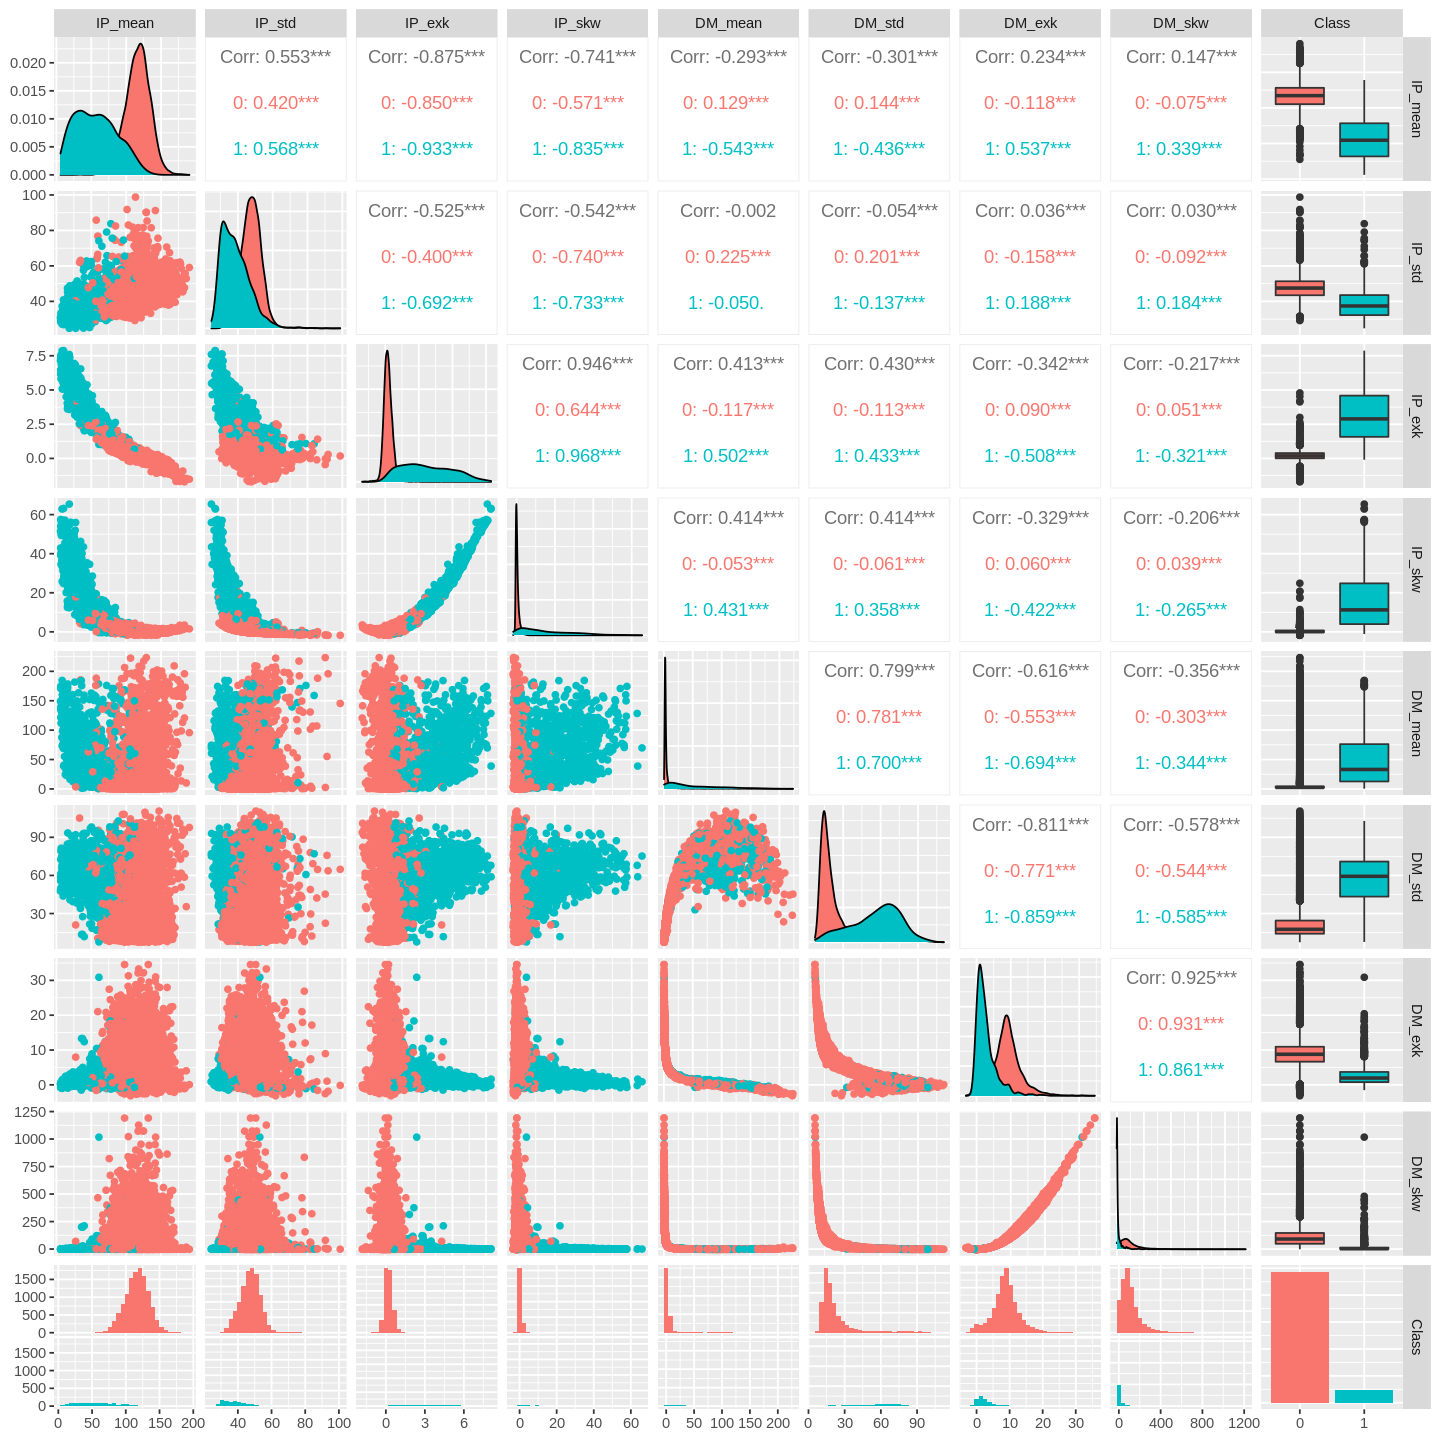

In [7]:
#next lets make a plot to show the relationships between the variables 
options(repr.plot.width = 12, repr.plot.height = 12)
var_pairs_plot <- ggpairs(star_train, aes(colour = as.factor(star_train$Class)))
var_pairs_plot

A grid containing multiple plots individually comparing pairs of vairables. The scatterplots are coloured by the class label of each data point, showing what variables each class may have similar or differing values for. This can be visualized by the separation of blue (pulsar stars) and red points (non-pulsar stars). The correlation value is reported for each plot. 

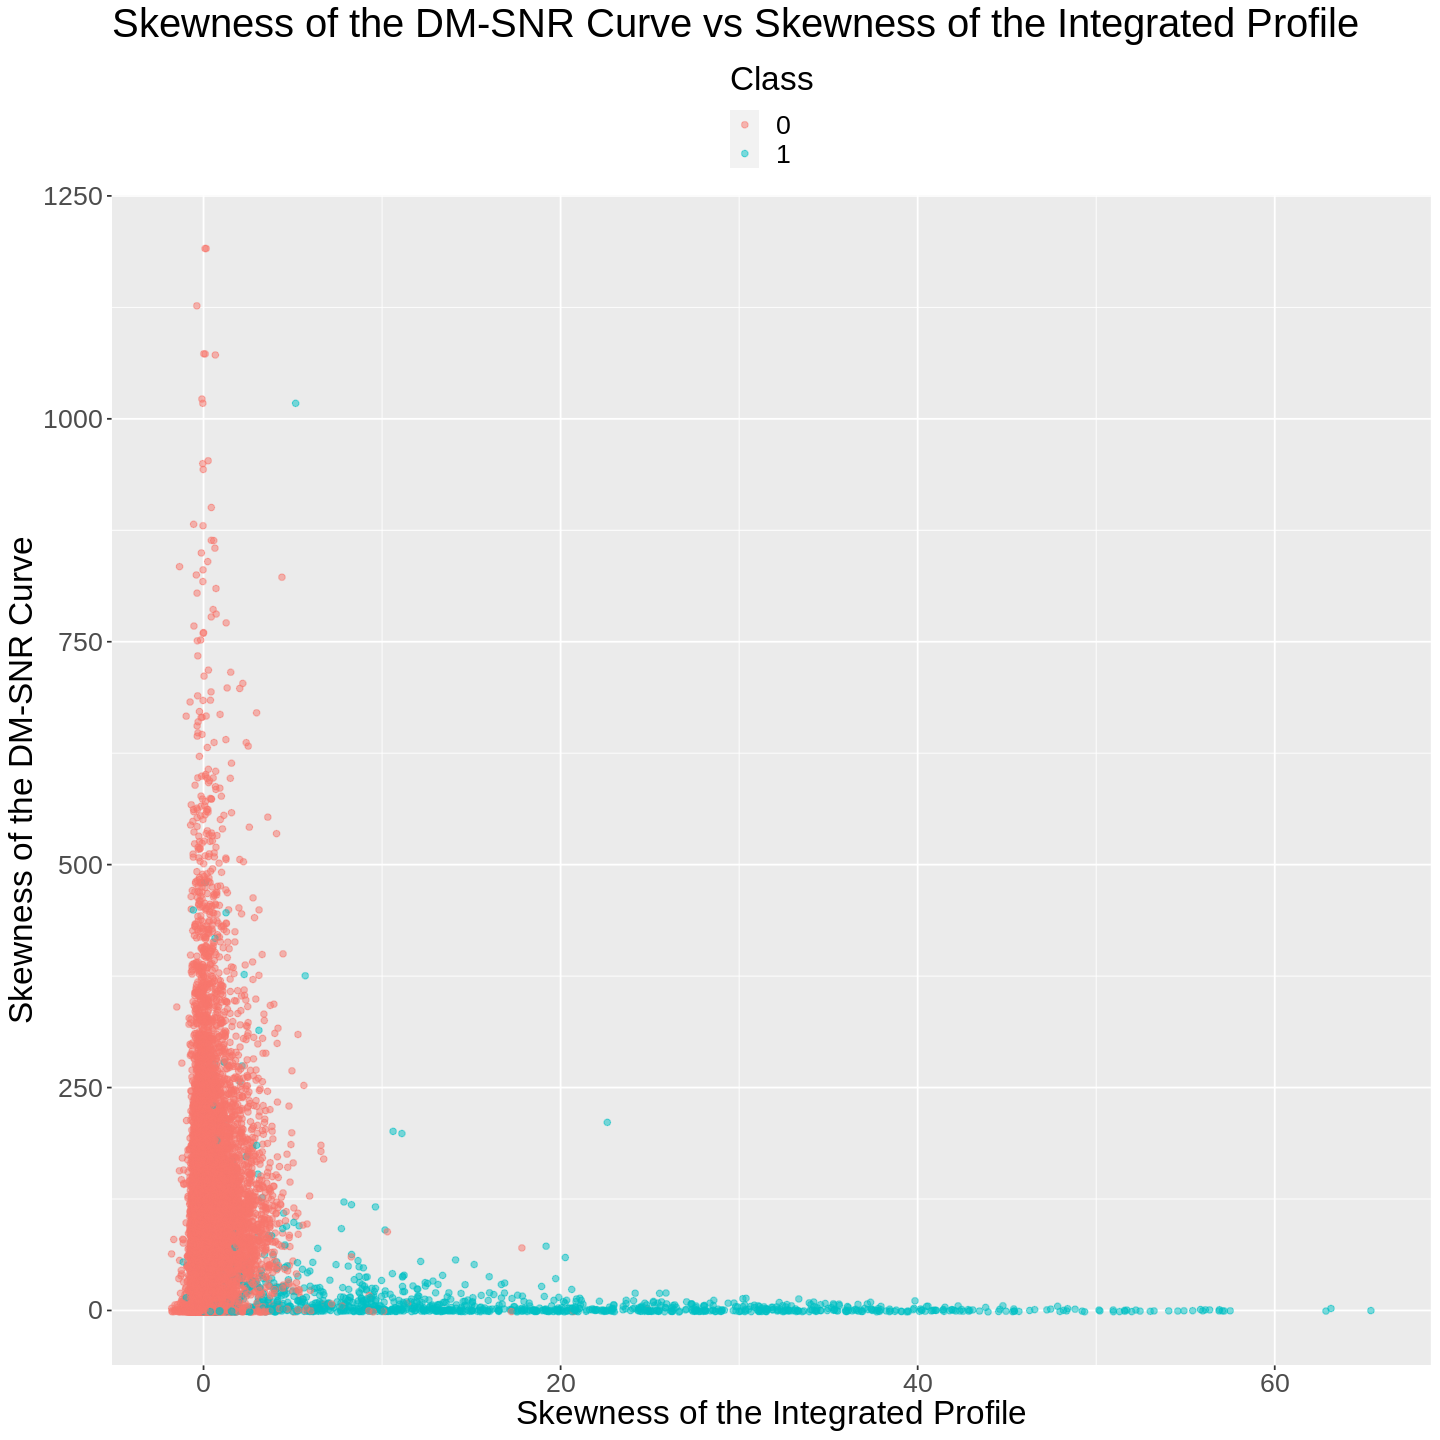

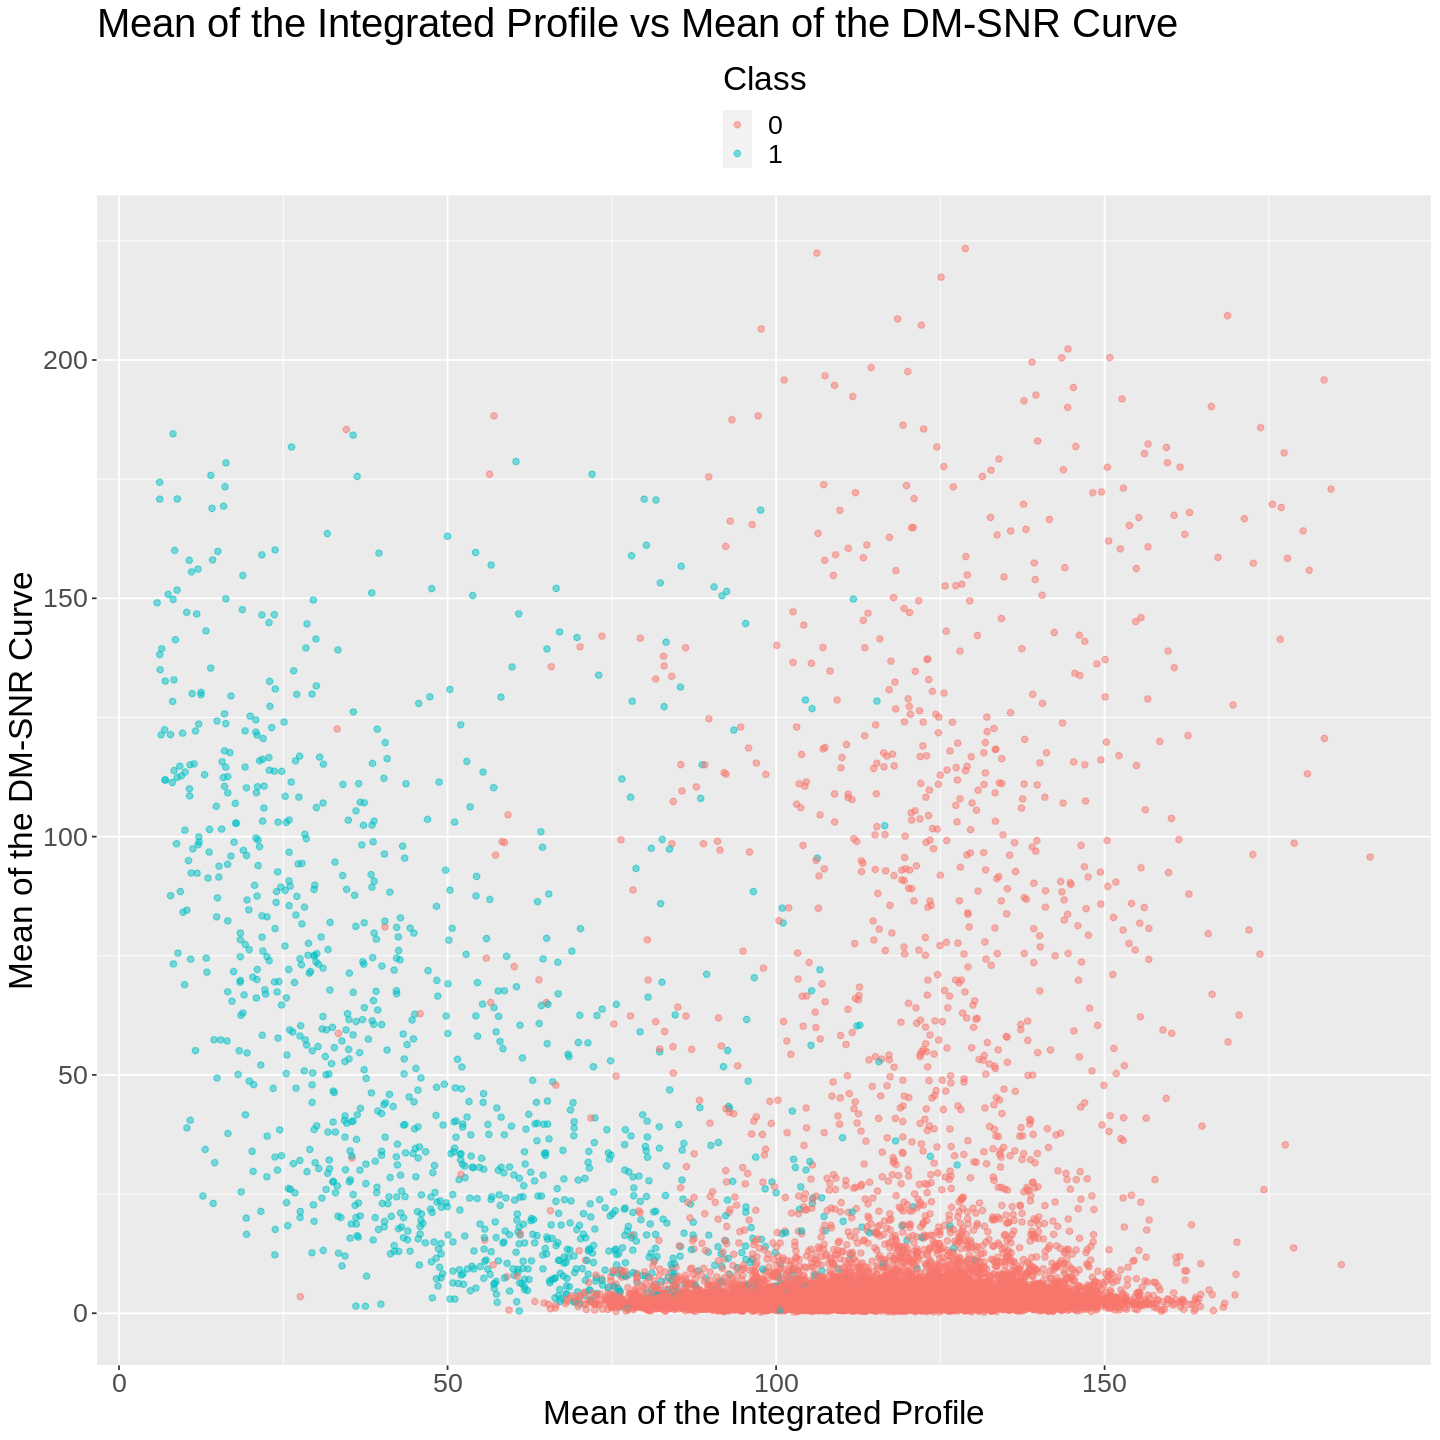

In [8]:
#based on table 1 and the variable pairs plot, we have chosen the following variables for our classification model: 
#IP_mean, IP_skw, DM_mean and DM_skw
#lets make plots of these variables that we can see a bit better
star_plot_2 <- ggplot(star_train, aes(x = IP_skw, y = DM_skw, color = Class)) +
geom_point(alpha = 0.5) +
xlab("Skewness of the Integrated Profile") +
ylab("Skewness of the DM-SNR Curve") +
ggtitle("Skewness of the DM-SNR Curve vs Skewness of the Integrated Profile") +
theme(text = element_text(size = 20), legend.position = "top", legend.direction = "vertical")
star_plot_2

star_plot_3 <- ggplot(star_train, aes(x = IP_mean, y = DM_mean, color = Class)) +
geom_point(alpha = 0.5) +
xlab("Mean of the Integrated Profile") +
ylab("Mean of the DM-SNR Curve") +
ggtitle("Mean of the Integrated Profile vs Mean of the DM-SNR Curve") +
theme(text = element_text(size = 20), legend.position = "top", legend.direction = "vertical")
star_plot_3

The above plots visualize the relationship between the 4 variables that will be used to classify pulsar stars. As seen, the points are once again coloured by class label (red for non-pulsar stars, blue for pulsar stars).

# Methods

We plan to conduct our data analysis using the K nearest neighbours algorithm to classify which stars are pulsar stars and which ones are not. We have chosen the following variables to conduct our analysis: 

1) Mean of the integrated profile (IP_mean) 

2) Skewness of the integrated profile (IP_skw) 
3) Mean of the DM-SNR curve (DM_mean) 
4) Skewness of the DM-SNR curve (DM_skw) 

We plan to create three classification models using the following combinations of predictors:
1) IP_skw and DM_skw
2) DM_mean and IP_mean
3) IP_mean , IP_skw, DM_mean and DM_skw

We have chosen these predictors so we can find out which metrics (skewness or mean) are most effective to predict whether a star is pulsar or not, by comparing the accuracy of the first two prediction models. In the end, we also plan to make a third classification model using all predictors to see if using more predictors increases the accuracy of our predictions. 

We propose to visualise the results through a grid of scatterplots for each classification model, to efficiently demonstrate which combination of predictors is most accurate. 

# Expected Outcome
We expect that the most effective way for astronomers to measure and observe stars will come from using the DM_skw and IP_skw. We made this prediction based on Table 1 which shows the biggest difference between pulsars and non-pulsars is with the skew. All three classification models will allow us to compare differences in variables to one another and lead to the most effective way for astronomers.  We will be using a third classification model with all the variables because we expect that a model with all the predictors should provide support in terms of accuracy. Our findings will have an impact on maximizing productivity and efficiency for astronomers as knowing which is the most effective way allows astronomers to be able to quickly determine whether a star is a pulsar or not. Our findings could lead to the questions: How much time are astronomers saving using the most effective method? Would using the other 4 variables in the dataset yield a more effective way to measure and observe stars?

# Data Analysis

In [10]:
#classification data analysis

#for DM_skw and IP_skw
#selecting k value, using cross validation 
star_tune1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

star_recipe <- recipe(Class ~ DM_skw + IP_skw, data = star_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

star_fold1 <- vfold_cv(star_train, v = 5, strata = Class)

star_results1 <- workflow() |>
add_recipe(star_recipe) |>
add_model(star_model) |>
tune_grid(resamples = star_fold, grid = 10) |>
collect_metrics()

accuracies1 <- star_results |>
filter(.metric == "accuracy")

k_selection1 <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") +
scale_x_continuous(breaks = 1:14) +
ggtitle("Accuracy Estimate vs Neighbors")
k_selection1

#use selected k value to classify
star_model1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
set_engine("kknn") |>
set_mode("classification")

star_workflow1 <- workflow() |>
add_model(star_model1) |>
add_recipe(star_recipe) |>
fit(data = star_train)

star_preds1 <- predict(star_workflow1, star_test) |>
bind_cols(star_test)

#evaluate accuracy of classifier 
star_pred_accuracy1 <- star_preds1 |>
metrics(truth = Class, estimate = .pred_class) |>
filter(.metric == "accuracy")
star_pred_accuracy1

star_matrix <- star_preds1 |>
conf_mat(truth = Class, estimate = .pred_class)
star_matrix

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9591002,5,0.0012310624,Preprocessor1_Model1
3,accuracy,binary,0.9717648,5,0.0012874714,Preprocessor1_Model2
5,accuracy,binary,0.9730313,5,0.0008865380,Preprocessor1_Model3
8,accuracy,binary,0.9738508,5,0.0007585232,Preprocessor1_Model4
9,accuracy,binary,0.9735528,5,0.0010734576,Preprocessor1_Model5
10,accuracy,binary,0.9735528,5,0.0010734576,Preprocessor1_Model6
12,accuracy,binary,0.9731057,5,0.0009608914,Preprocessor1_Model7
14,accuracy,binary,0.9732547,5,0.0010033775,Preprocessor1_Model8


In [23]:
#for DM_mean and IP_mean

In [24]:
#for DM_mean, IP_mean, DM_skw, and IP_skw

# References
1. R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar
	Candidate Selection: From simple filters to a new principled real-time classification approach
	MNRAS, 2016.